In [1]:
import numpy as np

import jax
# import jax.numpy as jnp
# import jax.random as jr
# from flax import nnx
# import flax.linen as nn
# import optax

import matplotlib.pyplot as plt
import scienceplots
from cmap import Colormap

In [4]:
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [186]:
cmap = Colormap("tol:nightfall").to_mpl()

### reference solution

In [187]:
# Parameters
x0 = -1.0
xN = 1.0
L = 2.0
nx = 1001
dx = L / (nx - 1)
nu = 0.01 / np.pi
dt = 0.0005
t_final = 1.0
nt = int(t_final / dt)

In [188]:
xs = np.linspace(x0, xN, nx)
U = np.zeros((nx, nt + 1))

U[:, 0] = -np.sin(np.pi * xs)

for n in range(nt):
    U[1:-1, n + 1] = (
        U[1:-1, n] 
        - dt / (2 * dx) * U[1:-1, n]  * (U[2:, n] - U[:-2, n])
        + nu * dt / dx**2 * (U[2:, n] - 2 * U[1:-1, n] + U[:-2, n])
    )
    U[0, n + 1] = U[-1, n + 1] = 0

ts = np.linspace(0, nt * dt, nt + 1)

X, T = np.meshgrid(xs, ts)

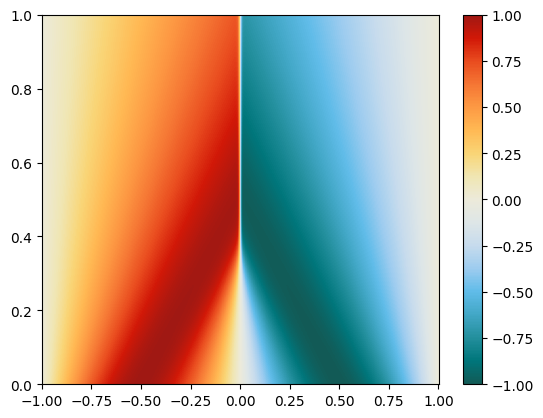

In [189]:
p = plt.pcolormesh(X, T, U.T, cmap=cmap)
plt.colorbar(p)

### basic pinn

In [190]:
N_COLLOCATION_POINTS = 8192
N_COLLOCATION_X = 2**6
N_COLLOCATION_T = 2**7
assert N_COLLOCATION_X * N_COLLOCATION_T == N_COLLOCATION_POINTS

N_IC_POINTS = 2048
N_BC_POINTS_PER_BOUNDARY = 1024

IC_WEIGHT = 10.0
BC_WEIGHT = 10.0

LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 20_000 # 20000

generation of points

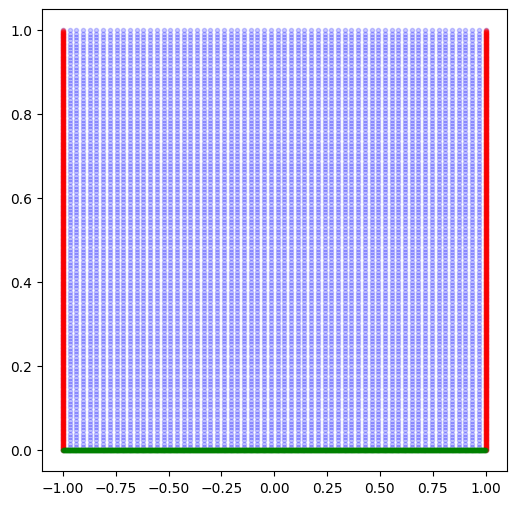

In [191]:
# collocation
x = np.linspace(x0, xN, N_COLLOCATION_X)
t = np.linspace(0, t_final, N_COLLOCATION_T)
coll_points = np.vstack(np.meshgrid(x, t)).reshape(2, -1).T

# BC
t = np.linspace(0, t_final, N_BC_POINTS_PER_BOUNDARY)
BC_points_left = np.vstack((x0 * np.ones(N_BC_POINTS_PER_BOUNDARY), t)).reshape(2, -1).T
BC_points_right = np.vstack((xN * np.ones(N_BC_POINTS_PER_BOUNDARY), t)).reshape(2, -1).T
BC_points = np.vstack((BC_points_left, BC_points_right))
BC_true = np.zeros(2 * N_BC_POINTS_PER_BOUNDARY)

# IC
x = np.linspace(x0, xN, N_IC_POINTS)
IC_points = np.vstack((x, np.zeros(N_IC_POINTS))).reshape(2, -1).T
IC_true = -np.sin(np.pi * IC_points[:, 0])

plt.figure(figsize=(6, 6))
plt.scatter(coll_points[:, 0], coll_points[:, 1], c="blue", marker='.', alpha=0.2)
plt.scatter(BC_points[:, 0], BC_points[:, 1], c="red", marker='.', alpha=0.2)
plt.scatter(IC_points[:, 0], IC_points[:, 1], c="green", marker='.', alpha=0.2)

In [192]:
width = 100

class MLP(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.hidden_layers = [
            nnx.Linear(2, width, rngs=rngs),  # First hidden layer
            nnx.Linear(width, width, rngs=rngs),  # Second hidden layer
            nnx.Linear(width, width, rngs=rngs),  # Third hidden layer
            nnx.Linear(width, width, rngs=rngs),  # Fourth hidden layer
            nnx.Linear(width, width, rngs=rngs),  # Fifth hidden layer
        ]
        self.output_layer = nnx.Linear(width, 1, rngs=rngs)  # Output layer

    def __call__(self, x):
        for layer in self.hidden_layers:
            x = nnx.relu(layer(x))  # Apply ReLU activation after each hidden layer
        x = self.output_layer(x)  # Final output layer
        return x

model = MLP(nnx.Rngs(0))
nnx.display(model)

MLP(
  hidden_layers=[Linear(
    kernel=Param(
      value=Array(shape=(2, 100), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(100,), dtype=float32)
    ),
    in_features=2,
    out_features=100,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x00000214A1D8B060>,
    bias_init=<function zeros at 0x00000214A12C7880>,
    dot_general=<function dot_general at 0x000002149FE162A0>
  ), Linear(
    kernel=Param(
      value=Array(shape=(100, 100), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(100,), dtype=float32)
    ),
    in_features=100,
    out_features=100,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x00000214A1D8B060>,
    bias_init=<function zeros at 0x00000214A12C7880>,
    dot_general=<function dot_general at 0x000002149

In [193]:
optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE))
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=MLP(
    hidden_layers=[Linear(
      kernel=Param(
        value=Array(shape=(2, 100), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(100,), dtype=float32)
      ),
      in_features=2,
      out_features=100,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x00000214A1D8B060>,
      bias_init=<function zeros at 0x00000214A12C7880>,
      dot_general=<function dot_general at 0x000002149FE162A0>
    ), Linear(
      kernel=Param(
        value=Array(shape=(100, 100), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(100,), dtype=float32)
      ),
      in_features=100,
      out_features=100,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.i

In [196]:
@nnx.jit
def loss_fn(model):
    def pde_residual(net, point):
        u_x = lambda p:jax.grad(lambda x, t: jnp.sum(net((x, t))), 0)(p[0], p[1])
        u_xx = lambda p:jax.grad(lambda x, t: jnp.sum(u_x((x, t))), 0)(p[0], p[1])
        u_t = lambda p:jax.grad(lambda x, t: jnp.sum(net((x, t))), 1)(p[0], p[1])

        return u_t(point) + net(point) * u_x(point) - nu * u_xx(point)

    pde_loss = jnp.mean(jnp.square(
        jax.vmap(pde_residual, (None, 0))(model, coll_points)))
    
    BC_loss = jnp.mean(jnp.square(
        jax.vmap(model)(BC_points) - BC_true[:, None]
    ))

    IC_loss = jnp.mean(jnp.square(
        jax.vmap(model)(IC_points) - IC_true[:, None]
    ))
    return pde_loss + BC_WEIGHT * BC_loss + IC_WEIGHT * IC_loss

@nnx.jit
def train_step(model, optimizer):
    grads: nnx.State = nnx.grad(loss_fn)(model)
    optimizer.update(grads)

In [197]:
for epoch in range(10_000):
    train_step(model, optimizer)

    if epoch % 100 == 0:
        loss = loss_fn(model)
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 0.34876254200935364
epoch: 100, loss: 0.35737183690071106
epoch: 200, loss: 0.3815373182296753
epoch: 300, loss: 0.41197142004966736


KeyboardInterrupt: 

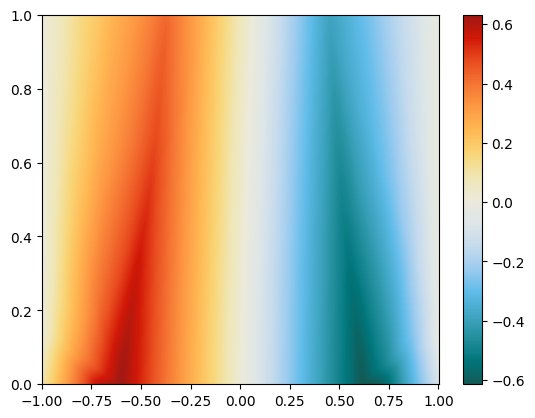

In [ ]:
fig, ax = plt.subplots()

grid_points = jnp.stack([X.ravel(), T.ravel()], axis=-1)
U_NN = jax.vmap(model)(grid_points)
U_NN = U_NN.reshape(X.shape)

p = plt.pcolormesh(X, T, U_NN, cmap=cmap)
plt.colorbar(p)